# Backtest all models to obtain a realistic pnl for each

In [222]:
import pandas as pd
import numpy as np
import datetime as dt

# Load daily closing prices for SPY, using'Date' column as DataFrame index & parsing trade dates to datetime objects 
data = pd.read_csv(r'price_data\SPY.csv',index_col="Date",parse_dates=True)

# define a specic dataframe
df_SP = pd.DataFrame(data['SPY'][data.index >= dt.datetime(2000, 1, 3)])
df_SP.head()

,SPY
Date,
2000-01-03,145.4375
2000-01-04,139.7500
2000-01-05,140.0000
2000-01-06,137.7500
2000-01-07,145.7500


### Calculate pnl for Buy & Hold SPY

In [223]:
# Calculate daily % returns of SPY and show the cumulative (compounded) returns over time 
df_SP['% Change'] = df_SP['SPY'].pct_change()
df_SP['cum_rets'] = (1 + df_SP['SPY'].pct_change()).cumprod()
#df_SP['pct Change'] = df_SP['SPY'].pct_change()
df_SP.head()

,SPY,% Change,cum_rets
Date,,,
2000-01-03,145.4375,NaN,NaN
2000-01-04,139.7500,-0.039106,0.960894
2000-01-05,140.0000,0.001789,0.962613
2000-01-06,137.7500,-0.016071,0.947142
2000-01-07,145.7500,0.058076,1.002149


In [230]:
SPY_mean = df_SP['% Change'].mean()*252
SPY_vol = df_SP['% Change'].std()*np.sqrt(252)

SPY_sharpe = SPY_mean / SPY_vol
SPY_mean, SPY_sharpe

(0.04993773408888486, 0.25552149970765753)

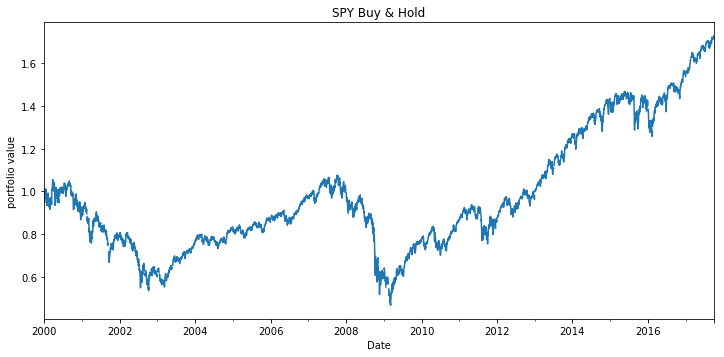

In [214]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

ax1 = plt.subplot(211)
df_SP['cum_rets'].plot(ax=ax1)
ax1.set_ylabel('portfolio value')
plt.title('SPY Buy & Hold')

#ax2 = plt.subplot(212, sharex=ax1)
#perf.AAPL.plot(ax=ax2)
#ax2.set_ylabel('AAPL stock price')

### Calculate pnl for Cash holdings (T-Bill - 30bps)

In [159]:
import pandas_datareader as web

#get the risk free rate (3 Month T-Bills)
rf_yearly = pd.DataFrame(web.DataReader("TB3MS", "fred", start=datetime.datetime(2000, 1, 1))['TB3MS'])

rf_yearly['TB3MS'] = rf_yearly['TB3MS'] - 0.30
rf_d = (rf_yearly.asfreq('D').fillna(method='pad'))/(365*100)

rf = rf_d.iloc[2:].resample('B').ffill()

rf.head()

,TB3MS
DATE,
2000-01-03,0.000138
2000-01-04,0.000138
2000-01-05,0.000138
2000-01-06,0.000138
2000-01-07,0.000138


In [160]:
# Calculate daily % returns of risk-free rate (3 Month T-Bills - 30 bps) & show cumulative (compounded) returns over time 
rf['% Change'] = (1 + rf['TB3MS'].iloc[1:]).cumprod()

rf.head()

,TB3MS,% Change
DATE,,
2000-01-03,0.000138,NaN
2000-01-04,0.000138,1.000138
2000-01-05,0.000138,1.000275
2000-01-06,0.000138,1.000413
2000-01-07,0.000138,1.000550


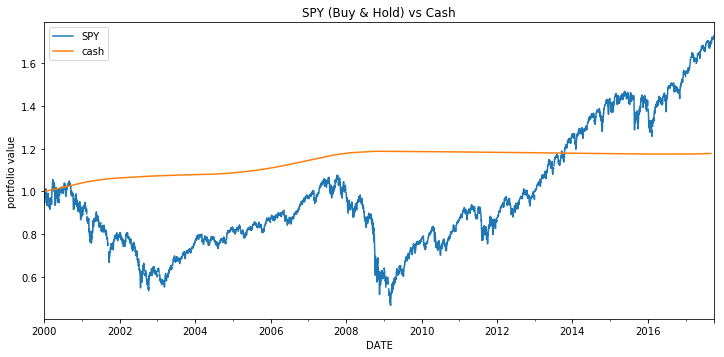

In [215]:
ax1 = plt.subplot(211)
df_SP['cum_rets'].plot(ax=ax1, label='SPY')
ax1.set_ylabel('portfolio value')
plt.title('SPY (Buy & Hold) vs Cash')

ax2 = plt.subplot(211)
rf['% Change'].plot(ax=ax2, label='cash')

plt.legend(loc=0)

### Model Backtests - Predicted Returns

#### simpLR - similar to 'Kitchen Sink' model in Hull paper

In [250]:
df_simp = pd.read_csv(r'Predicted_Return\PredReturn_simpLR.csv',names=['Date', 'pred_ret'],index_col='Date',parse_dates=True)

df_simp.head()

,pred_ret
Date,
2000-01-03,0.030057
2000-01-04,0.066202
2000-01-05,0.047462
2000-01-06,0.055647
2000-01-07,0.052698


In [251]:
mult = 8
df_simp['pos_size'] = (df_simp['pred_ret'] * mult).round(1).clip(-0.5,1.5)
#df_simp['pos_size'].clip(-0.5,1.5)

df_simp.head()

,pred_ret,pos_size
Date,,
2000-01-03,0.030057,0.2
2000-01-04,0.066202,0.5
2000-01-05,0.047462,0.4
2000-01-06,0.055647,0.4
2000-01-07,0.052698,0.4


In [254]:
df_ret = df_SP.join(pd.DataFrame({'simp_pos' : df_simp['pos_size'][df_simp.index >= dt.datetime(2000, 1, 3)]}))
#data.join(pd.DataFrame({'VSTOXX' :
                              #vs['V2TX'][vs.index > dt.datetime(1999, 1, 1)]}))
df_ret.head()    

,SPY,% Change,cum_rets,simp_pos
Date,,,,
2000-01-03,145.4375,NaN,NaN,0.2
2000-01-04,139.7500,-0.039106,0.960894,0.5
2000-01-05,140.0000,0.001789,0.962613,0.4
2000-01-06,137.7500,-0.016071,0.947142,0.4
2000-01-07,145.7500,0.058076,1.002149,0.4


In [268]:
# Calculate model returns by multiplying previous day's position size (-0.5 to 1.5) by the following day's SPY return
# ==> This simulates putting on the desired position at the closing price on trade date 't' & recording its performance on 't+1'

# takingthe previous day's position size is done by applying a 'shift()' function to the time series data
df_ret['simp(% Change)'] = (df_ret['SPY'].pct_change()) * df_ret['simp_pos'].shift(1)
df_ret['simp(cum_rets)'] = (1 + (df_ret['SPY'].pct_change() * df_ret['simp_pos'].shift(1))).cumprod()

df_ret.head()

,SPY,% Change,cum_rets,simp_pos,simp(% Change),simp(cum_rets)
Date,,,,,,
2000-01-03,145.4375,NaN,NaN,0.2,NaN,NaN
2000-01-04,139.7500,-0.039106,0.960894,0.5,-0.007821,0.992179
2000-01-05,140.0000,0.001789,0.962613,0.4,0.000894,0.993066
2000-01-06,137.7500,-0.016071,0.947142,0.4,-0.006429,0.986682
2000-01-07,145.7500,0.058076,1.002149,0.4,0.023230,1.009603


In [270]:
simp_mean = df_ret['simp(% Change)'].mean()*252
simp_vol = df_ret['simp(% Change)'].std()*np.sqrt(252)

simp_sharpe = simp_mean / simp_vol
simp_mean, simp_sharpe

(0.13354511809906863, 0.98580274118009847)

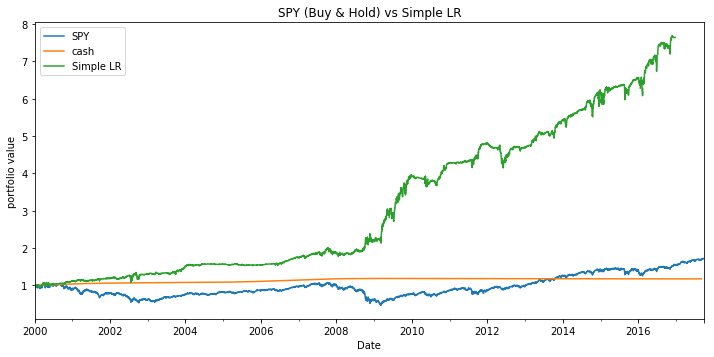

In [271]:
ax1 = plt.subplot(211)
df_ret['cum_rets'].plot(ax=ax1, label='SPY')
ax1.set_ylabel('portfolio value')
plt.title('SPY (Buy & Hold) vs Simple LR')

ax2 = plt.subplot(211)
rf['% Change'].plot(ax=ax2, label='cash')

ax3 = plt.subplot(211)
df_ret['simp(cum_rets)'].plot(ax=ax3, label='Simple LR')
plt.legend(loc=0)